"Portal Transparencia" Web Scraping
==

## 1. Capturing employees from UFRN and IFRN

The aim of this task is to capture employees data from IES (Ministry of Education), specifically UFRN and IFRN. Using the Web Scraping strategy, on site [Porta Transparência] (http://www.portaltransparencia.gov.br), was possible to capture employees data, including payslip data. 
 
 
### 1.1 Download the IES Institutions from MEC

  The first step is download the institutions data hierarchically below from MEC. This data is important to get the Institutions Ids. We need only the Ids from UFRN and IFRN. As example, we show below the code to download one page only:
  

In [5]:
# import package
from requests import get
from bs4 import BeautifulSoup
import re
import pandas as pd

urlorgaos = 'http://www.portaltransparencia.gov.br/servidores/' \
            'OrgaoExercicio-ListaOrgaos.asp?CodOS=%s&Pagina=%s'

codmec = '15000'

response = get(urlorgaos % (codmec,1))
html_soup = BeautifulSoup(response.text, 'html.parser')
paginas = html_soup.find('p', class_='paginaAtual')
paginas = paginas.text.split('/')[1]

codorgaos = []
nomeorgaos = []
nservidoresorgaos = []

i = 1
response = get(urlorgaos % (codmec,i+1))
html_soup = BeautifulSoup(response.text, 'html.parser')

table = html_soup.find('table', summary=re.compile('Lista'))

trs = table.find_all('tr')
for ltr in trs:
    if not ltr.find('td'):
        continue
    else:
        ltd = ltr.find_all('td')
        codorgaos.append(ltd[0].text.strip())
        nomeorgaos.append(ltd[1].a.text.strip())
        nservidoresorgaos.append(ltd[2].text.strip())

orgaos = pd.DataFrame({'idorgao':codorgaos, 'nomeorgao':nomeorgaos, 'totalservidores':nservidoresorgaos})
print(orgaos.head())

  idorgao                                 nomeorgao totalservidores
0   26272         FUNDACAO UNIVERSIDADE DO MARANHAO            3986
1   26251   FUNDACAO UNIVERSIDADE FED. DO TOCANTINS            2045
2   26278  FUNDACAO UNIVERSIDADE FEDERAL DE PELOTAS            2943
3   26281  FUNDACAO UNIVERSIDADE FEDERAL DE SERGIPE            3371
4   26352      FUNDACAO UNIVERSIDADE FEDERAL DO ABC            1483



The above script should run a loop over all pages and to save the resulting dataframe on file ('orgaos_mec.csv').

### 1.2 Download the employees data from UFRN and IFRN

The second step is download the employees list from institutions (UFRN, IFRN) using the informations from 'orgaos_mec.csv'. Again, the follow example demonstrate only one page web scraping


In [12]:
from requests import get 
from bs4 import BeautifulSoup
import os
import csv
import re
import pandas as pd

csv_servidores = 'servidores_orgao.csv'
csv_fieldnames = ['idorgao','idservidor','nomeservidor']

urlservidores = 'http://www.portaltransparencia.gov.br/servidores/' \
                'OrgaoExercicio-ListaServidores.asp?CodOrg=%s&Pagina=%s'

codorgaos = []
nomeorgaos = []
nservidoresorgaos = []

orgaosmec = pd.read_csv('orgaos_mec.csv')

org_rn = orgaosmec[orgaosmec['nomeorgao'].str.contains('RIO GRANDE DO NORTE')]

print('Resumo:')
print(org_rn)

for codorg in org_rn['idorgao'].tolist():
    print('Id Orgao: ',codorg, 'Nome Orgao: ',org_rn.loc[org_rn['idorgao']==codorg]['nomeorgao'])
    response = get(urlservidores % (codorg,1))
    html_soup = BeautifulSoup(response.text, 'html.parser')
    paginas = html_soup.find('p', class_='paginaAtual')
    paginas = paginas.text.split('/')[1]

    idorgao = []
    idservidor = []
    nomeservidor = []
    
    i = 1
    response = get(urlservidores % (codorg, (i+1)))
    html_soup = BeautifulSoup(response.text, 'html.parser')

    table = html_soup.find('table', summary=re.compile('Lista'))

    trs = table.find_all('tr')
    for ltr in trs:
        if not ltr.find('td'):
            continue
        else:
            ltd = ltr.find_all('td')
            nomeservidor.append(ltd[1].a.text.strip())
            link = ltd[1].a.get('href').split('?')
            id = [par.split('=')[1] for par in link[1].split('&') if 'IdServidor' in par]
            idorgao.append(codorg)
            idservidor.append(id[0])
    servidores = pd.DataFrame({'idorgao': idorgao, 'idservidor': idservidor, 'nomeservidor': nomeservidor})
    print(servidores.head())


Resumo:
    idorgao                                 nomeorgao  totalservidores
54    26435  INSTITUTO FEDERAL DO RIO GRANDE DO NORTE             2691
74    26243  UNIVERSIDADE FED. DO RIO GRANDE DO NORTE             6183
Id Orgao:  26435 Nome Orgao:  54    INSTITUTO FEDERAL DO RIO GRANDE DO NORTE
Name: nomeorgao, dtype: object
   idorgao idservidor                nomeservidor
0    26435    1934686  ADAO MARCELO DA ROCHA NETO
1    26435    1531794      ADDSON ARAUJO DA COSTA
2    26435    1970413  ADELMARIA CORDEIRO DE SENA
3    26435    1189886    ADELMO TORQUATO DA SILVA
4    26435    1144846        ADELSON LUIZ DE LIMA
Id Orgao:  26243 Nome Orgao:  74    UNIVERSIDADE FED. DO RIO GRANDE DO NORTE
Name: nomeorgao, dtype: object
   idorgao idservidor                        nomeservidor
0    26243    1816384            ADAILTON GARCIA DA SILVA
1    26243    1776922          ADALA NAYANA DE SOUSA MATA
2    26243    1783243  ADALBERTO ALMEIDA DE ARAUJO JUNIOR
3    26243    2152285   ADALBER


The above script, on its complete view, will run the web scraping on all pages from two institutions (UFRN and IFRN) employees lists and the results dataframes are stored on respectives csv files (26243.csv and 26435.csv)

### 1.3 Extracting data from employees

The third step is extracting the employees data based on institutions employees list that we did get on last step. It turns out, the employees data are split on two area drom portal: The first one is data related to employees roles and their functional life. The second is related of payment receipts(payslip). Therefore, the webscraping was done on two steps.


In [8]:
from requests import get 
from bs4 import BeautifulSoup
import os
import json
import re
import pandas as pd
import time
from random import randint

urlbase = 'http://www.portaltransparencia.gov.br'
urldetalheservidor = 'http://www.portaltransparencia.gov.br/servidores/' \
                     'OrgaoExercicio-DetalhaServidor.asp?' \
                     'IdServidor=%s&CodOrgao=%s'

csv_servidores = 'servidores_orgao.csv'
csv_fieldnames = ['idorgao','idservidor','nomeservidor']

orgaosmec = pd.read_csv('orgaos_mec.csv')

org_rn = orgaosmec[orgaosmec['nomeorgao'].str.contains('RIO GRANDE DO NORTE')]
for codorg in org_rn['idorgao'].tolist():
    print('Id Orgao: ',codorg, 'Nome Orgao: ',org_rn.loc[org_rn['idorgao']==codorg]['nomeorgao'])
    filename = str(codorg)+'.csv'
    df_servidores = pd.read_csv(filename)

    registros = {}
    id = 0

    for idservidor in df_servidores['idservidor'].tolist():
        try:
            response = get(urldetalheservidor % (idservidor,codorg))
        except:
            print('Error: Server timeout')
        html_soup = BeautifulSoup(response.text, 'html.parser')

        # Ficha de Dados

        resumo = html_soup.find('div', id='conteudo').find('div', id='resumo')
        rlist = resumo.find_all('td', class_='firstChild')
        registros[str(id)] = {}
        for r in rlist:
            label = r.nobr.string.split(':')[0].strip()
            valor = r.next_sibling.next_sibling.string.strip()
            if valor:
                valor = valor.strip()
            registros[str(id)][label] = valor
        linkremuneracao = resumo.a.get('href')
        registros[str(id)]['linkremuneracao'] = linkremuneracao
        detalhes = html_soup.find('div', id='listagemConvenios'). \
            find_all('table', summary=re.compile('Detalhes'))
        for det in detalhes:
            dlist = det.find_all('td', class_='tituloDetalhe')
            for d in dlist:
                label = d.string.string.split(':')[0].strip()
                valor = d.next_sibling.next_sibling.strong.string
                if valor:
                    valor = valor.strip()
                registros[str(id)][label] = valor

        time.sleep(randint(1, 3))

        # Remuneracao

        urlremuneracao = urlbase + linkremuneracao

        try:
            response_rem = get(urlremuneracao)
        except:
            print('Error: Server timeout')

        html_soup_rem = BeautifulSoup(response_rem.content, 'html.parser')

        conv = html_soup_rem.find('div', id='listagemConvenios')
        mesref = conv.find('tr', class_='remuneracaohead1')
        mesref = mesref.th.string.split(':')[1].strip()

        registros[str(id)]['mesremuneracao'] = mesref

        lremun = conv.table.tbody.find_all('tr')

        for i in lremun:
            v = i.find('td', class_='colunaValor')
            if v:
                valor = v.string
                if valor:
                    valor = valor.replace('.', '')
                    valor = valor.replace(',', '.').strip()
                    l = v.previous_sibling.previous_sibling
                    if valor:
                        registros[str(id)][l.string] = valor

        print(id, registros[str(id)]['Nome'])
        id += 1
        if id > 2:
            break

    servidores = pd.DataFrame(registros).transpose()
    print(servidores)


Id Orgao:  26435 Nome Orgao:  54    INSTITUTO FEDERAL DO RIO GRANDE DO NORTE
Name: nomeorgao, dtype: object
0 ABDON SILVA RIBEIRO DA CUNHA
1 ABIGAIL NOADIA BARBALHO DA SILVA
2 ABINOAM SOARES DA SILVA
  Ato de Ingresso no Órgão Ato de nomeação/contratação             CPF  \
0                 CONTRATO                              ***.591.254-**   
1                 PORTARIA                              ***.409.247-**   
2                 PORTARIA                              ***.481.964-**   

                             Cargo Emprego Classe  \
0  PROF ENS BAS TEC TECNOLOGICO-SUBSTITUTO      D   
1    PROFESSOR ENS BASICO TECN TECNOLOGICO      D   
2                            ADMINISTRADOR      E   

  Data da Última Alteração no Cargo Data da última alteração no Órgão  \
0                        21/03/2016                        30/04/2016   
1                        01/03/2013                        11/10/2011   
2                        01/02/2011                        30/12/2010  


The previous script to extract employes data was modified to run a example of captured rows. The real version, however, extract all employes data and save then on files (CSV) to future data processing. The generated dataframe contians all fields showed on "Portal da Transparência". 

## 2. Gender

### 2.1 Gender discover

The challenge to include de gender information on employees dataframes starting by the search for web services with gender informations based on the first name of person. The [IBGE](https://www.ibge.gov.br/) has a group of [API tools](https://servicodados.ibge.gov.br/api/docs) and, among then, the "Names" API. For this API, it has been seen that there is a tool to R language: [GenderBR](https://github.com/meirelesff/genderBR). However, it would be better if had a tool to Python language. Therefor, i develop a library to interface with "Names" IBGE API. The python library was named [pygenderbr](https://github.com/alexfurtunatoifrn/pygenderbr).

The pygenderbr have basically the same functions of genderBR. Since the IBGE API has the feature that allow querying multiple names at same time, the pygenderbr has this feature, allowing querying of up to ten names at same time.

The script query for employees gender using pygenderbr on IBGE API. Employees whose gender has not found, were used in query on another web service, named [Namsor](http://www.namsor.com). Since the remaining ones were less than a thousand(limit for namsor free use for a month), the namsor was sufficient for these cases.

Following, we have the script(example only) for the initial query, on IBGE API:

In [1]:
import pandas as pd
from pygenderbr import Gender
import time
from random import randint

g = Gender()

dados = 'servidores_26435.csv'
dados_df = pd.read_csv(dados)

print(len(dados_df),' registros encontrados')

#nomes = dados_df['Nome']
nomes = pd.DataFrame(dados_df['Nome'],columns=['Nome'])

nomes['pnome'] = nomes['Nome'].apply(lambda x: x.split()[0])
uniq_pnomes = nomes['pnome'].unique()

print(len(uniq_pnomes), 'nomes únicos encontrados')

n = 10
chunk_pnomes = [list(uniq_pnomes[i:i+n]) for i in range(0, len(uniq_pnomes), n)]

nomes_gender = pd.Series()
qnomes_chunk = 1
while chunk_pnomes:
    print('Processando Chunk: ',qnomes_chunk)
    lnomes = chunk_pnomes.pop()
    lgender = g.getgender(lnomes, threshold=0.75)
    nomes_gender = nomes_gender.append(lgender)
    print(lgender)
    qnomes_chunk += 1
    time.sleep(randint(1, 5))
    if qnomes_chunk > 3:
        break

nomes['gender'] = nomes['pnome'].map(lambda x: nomes_gender[x] if (x in nomes_gender.index) else '')

print('Encontrados: ')
print(nomes['gender'].value_counts())



2691  registros encontrados
1256 nomes únicos encontrados
Processando Chunk:  1
name
FRANK          M
FRANKILEIDE     
FRANSUELIO     M
FREDERICO      M
FREUD          M
GABRIEL        M
Name: gender, dtype: object
Processando Chunk:  2
name
FRANCIMARA      F
FRANCINAIDE     F
FRANCINALVA     F
FRANCINE        F
FRANCISCA       F
FRANCISCO       M
FRANCISLAINE    F
FRANCLIN        M
FRANCSIDEMAR     
FRANCY          F
Name: gender, dtype: object
Processando Chunk:  3
name
FLANELSON      
FLAVIA        F
FLAVIO        M
ALEX          M
FLORENCIO     M
FRANCARLOS    M
FRANCESCO     M
FRANCIELIO    M
FRANCIELLY    F
FRANCILENE    F
Name: gender, dtype: object
Encontrados: 
     2566
M     101
F      24
Name: gender, dtype: int64



### 2.2 Remaining data 

The above script, on you complete form, found the following employees gender count:

 - IFRN (2691 employees)
   - Found 2486 gender information from employees (205 fault)
 - UFRN (6183 employees)
   - Found 5797 gender information from employees (386 fault)

The following script was used to query the remaining employees on namsor:


In [7]:
from requests import get

url_namsor = 'https://api.namsor.com/onomastics/api/json/gender/%s/%s'

ifrn = pd.read_csv('servidores_26435_ibge.csv')
ifrn_remaining = pd.DataFrame(ifrn.loc[pd.isnull(ifrn['Sexo'])])
ifrn_remaining['fnome'] = ifrn_remaining['Nome'].map(lambda x: x.split()[0])
ifrn_remaining['lnome'] = ifrn_remaining['Nome'].map(lambda x: x.split()[-1])

print('Processing remaining on namsor: ', len(ifrn_remaining),' employees')

n = 1
for i,l in ifrn_remaining.iterrows():
    try:
        g = get(url_namsor % (l['fnome'],l['lnome']))
        g = g.json()
        s = g['gender']
        if s == 'male':
            s = 'M'
        elif s == 'female':
            s = 'F'
        else:
            s = ''
    except:
        s = ''
    l['Sexo'] = s
    print(n,' : ',l['fnome'],l['lnome'],' - ',s)
    n += 1
    if n > 4:
        break
    time.sleep(randint(1,4))

Processing remaining on namsor:  205  employees
1  :  GALBA ARAGAO  -  M
2  :  GENECI MEDEIROS  -  F
3  :  GENICKSON CARVALHO  -  M
4  :  GENICLEIDY BITTENCOURT  -  
5  :  GENNISSON CARNEIRO  -  M
6  :  GEOGENES LIMA  -  M
7  :  GERLUZIA ALVES  -  F
8  :  GIOVANNINNI BATISTA  -  
9  :  GIRLEIDSON RODRIGUES  -  M



The above script, on you complete form, found the following employees gender count using the Namsor:

 - IFRN (205 remaining employees)
   - Found 164 gender information (41 fault)
 - UFRN (386 remaining employees)
   - Found 283 gender information (103 fault)

The last 144 employees without gender information were manually set by full name view.


## 3. Data Analisys

### 3.1 Veryfying data

After defined all employees gender, we start the data analysis to find some relationships between employees informations, considering the gender of them.


In [67]:
# Starting viewing dataframe

ifrn = pd.read_csv('servidores_26435_genero.csv')
ufrn = pd.read_csv('servidores_26243_genero.csv')

if_uf = pd.concat([ifrn,ufrn], ignore_index=True)

print('Dataframe columns: ')
print(if_uf.columns)

print('\nSome rows data example: ')
print(ifrn[['Nome', 'Cargo Emprego', 'Órgão', 'Sexo']].head())
print(ufrn[['Nome', 'Cargo Emprego', 'Órgão', 'Sexo']].head())

Dataframe columns: 
Index(['Abate Teto', 'Atividade', 'Ato de Ingresso no Órgão',
       'Ato de nomeação/contratação',
       'CONSELHO CURADOR DOS HONORÁRIOS ADVOCATÍCIOS CCHA*', 'CPF',
       'Cargo Emprego', 'Classe', 'Data da Última Alteração no Cargo',
       'Data da Última Promoção', 'Data da última alteração na função',
       'Data da última alteração no Órgão', 'Data de nomeação/contratação',
       'Data de publicação', 'Demais deduções', 'Documento Legal',
       'Fundo de Saúde', 'Função', 'Função Gratificada', 'Férias',
       'Gratificação natalina', 'IRRF', 'Jornada de Trabalho',
       'Local de Exercício - Localização', 'Matrícula', 'Nome', 'Nível',
       'Número Doc. Legal', 'Ocorrência de Afastamento/Licença',
       'Opção parcial', 'Outras remunerações eventuais',
       'PSS/RPGS (Previdência Oficial)', 'Padrão', 'Pensão Militar',
       'Posto/Graduação', 'Referência', 'Regime Jurídico',
       'Remuneração básica bruta', 'Servidor', 'Sexo', 'Situação Vínculo'


### 3.2 Gender Statistics

Percent distribution of gender 

In [126]:
print('IFRN :')
ifrn_gender = ifrn.groupby(['Sexo']).size()
print(100*ifrn_gender/ifrn_gender.sum())

print('\nUFRN :')
ufrn_gender = ufrn.groupby(['Sexo']).size()
print(100*ufrn_gender/ufrn_gender.sum())



IFRN :
Sexo
F    37.421033
M    62.578967
dtype: float64

UFRN :
Sexo
F    48.423096
M    51.576904
dtype: float64


In [110]:
print('IFRN - Chefias:')
ifrn_fg = ifrn.loc[~pd.isnull(ifrn['Função Gratificada'])]
ifrn_fg = ifrn_fg.groupby(['Sexo']).size()
print(100*ifrn_fg/ifrn_fg.sum())

print('\nUFRN - Chefias:')
ufrn_fg = ufrn.loc[~pd.isnull(ufrn['Função Gratificada'])]
ufrn_fg = ufrn_fg.groupby(['Sexo']).size()
print(100*ufrn_fg/ufrn_fg.sum())


IFRN - Chefias:
Sexo
F    26.908397
M    73.091603
dtype: float64

UFRN - Chefias:
Sexo
F    42.467719
M    57.532281
dtype: float64



As can be seen, the IFRN has for a third of your  employees of women, while the UFRN has almost half. However, when considered only the chiefs, the percent of women is lower.

### 3.3  Anothers Statistics

Bellow, we'll show other interesting insights about the employees and your positions on that institutions


In [108]:
# Job Titles

# filtering missing data
ifrn_jt = pd.DataFrame(ifrn.loc[~pd.isnull(ifrn['Cargo Emprego'])])
ufrn_jt = pd.DataFrame(ufrn.loc[~pd.isnull(ufrn['Cargo Emprego'])])

print('Total Employess with job title: ')
print('IFRN = %s from %s' % (len(ifrn_jt),len(ifrn)))
print('UFRN = %s from %s' % (len(ufrn_jt),len(ufrn)))

print('\nUnique job titles: ')
print('IFRN = %s, %5.2f%%' % (len(ifrn_jt['Cargo Emprego'].unique()),100*len(ifrn_jt['Cargo Emprego'].unique())/len(ifrn)))
print('UFRN = %s, %5.2f%%' % (len(ufrn_jt['Cargo Emprego'].unique()),100*len(ufrn_jt['Cargo Emprego'].unique())/len(ufrn)))

# Create a job type column
ifrn_jt['tipocargo'] = ifrn_jt['Cargo Emprego'].map(lambda x: 'DOCENTE' if x.split()[0].startswith('PROF') else 'TECNICO')
ufrn_jt['tipocargo'] = ufrn_jt['Cargo Emprego'].map(lambda x: 'DOCENTE' if x.split()[0].startswith('PROF') else 'TECNICO')

# percent of Job Types (DOCENTE, TECNICO)
print('\nPercent of Job types: ')
print('IFRN:')
ifrn_jt_subt = ifrn_jt.groupby(['tipocargo']).size()
print(100*ifrn_jt_subt/ifrn_jt_subt.sum())
print('\nUFRN:')
ufrn_jt_subt = ufrn_jt.groupby(['tipocargo']).size()
print(100*ufrn_jt_subt/ufrn_jt_subt.sum())

Total Employess with job title: 
IFRN = 2691 from 2691
UFRN = 5675 from 6183

Unique job titles: 
IFRN = 85,  3.16%
UFRN = 155,  2.51%

Percent of Job types: 
IFRN:
tipocargo
DOCENTE    57.748049
TECNICO    42.251951
dtype: float64

UFRN:
tipocargo
DOCENTE    47.788546
TECNICO    52.211454
dtype: float64


#### Abate Teto

According of Brazilans laws, there is a maximum salary limit for employees of government institutions. Persons who receive beyond this limit have a discount called "Abate Teto". bellow is showed how many employees have these discount:


In [96]:
print('IFRN: ')
print(ifrn.loc[~pd.isnull(ifrn['Abate Teto'])][['Cargo Emprego','Remuneração básica bruta']])

print('UFRN: ')
print(ufrn.loc[~pd.isnull(ufrn['Abate Teto'])][['Cargo Emprego','Remuneração básica bruta']].sort_values('Remuneração básica bruta',ascending=False))

IFRN: 
                              Cargo Emprego  Remuneração básica bruta
2615  PROFESSOR ENS BASICO TECN TECNOLOGICO                  41701.21
UFRN: 
                                 Cargo Emprego  Remuneração básica bruta
792           PROFESSOR DO MAGISTERIO SUPERIOR                  46284.99
1962          PROFESSOR DO MAGISTERIO SUPERIOR                  44634.77
3855          PROFESSOR DO MAGISTERIO SUPERIOR                  43196.19
4008          PROFESSOR DO MAGISTERIO SUPERIOR                  42474.74
1338                               MEDICO-AREA                  42045.57
3203          PROFESSOR DO MAGISTERIO SUPERIOR                  41844.59
3463          PROFESSOR DO MAGISTERIO SUPERIOR                  41645.74
335           PROFESSOR DO MAGISTERIO SUPERIOR                  41395.15
3104          PROFESSOR DO MAGISTERIO SUPERIOR                  40862.62
1964                               MEDICO-AREA                  40573.57
3594          PROFESSOR DO MAGISTERIO SUPER

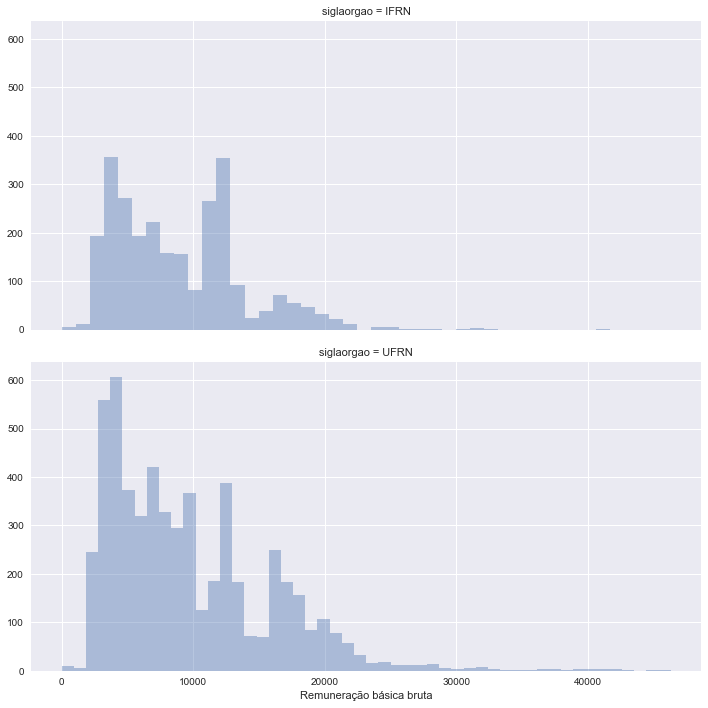

In [61]:
# Plotting the distribution of employees fees by institutions

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_context('notebook')

if_uf_rem = if_uf[~pd.isnull(if_uf['Remuneração básica bruta'])]

g = sns.FacetGrid(if_uf_rem, row="siglaorgao",size=5, aspect=2,)
g.map(sns.distplot, 'Remuneração básica bruta', kde=False);

plt.show()

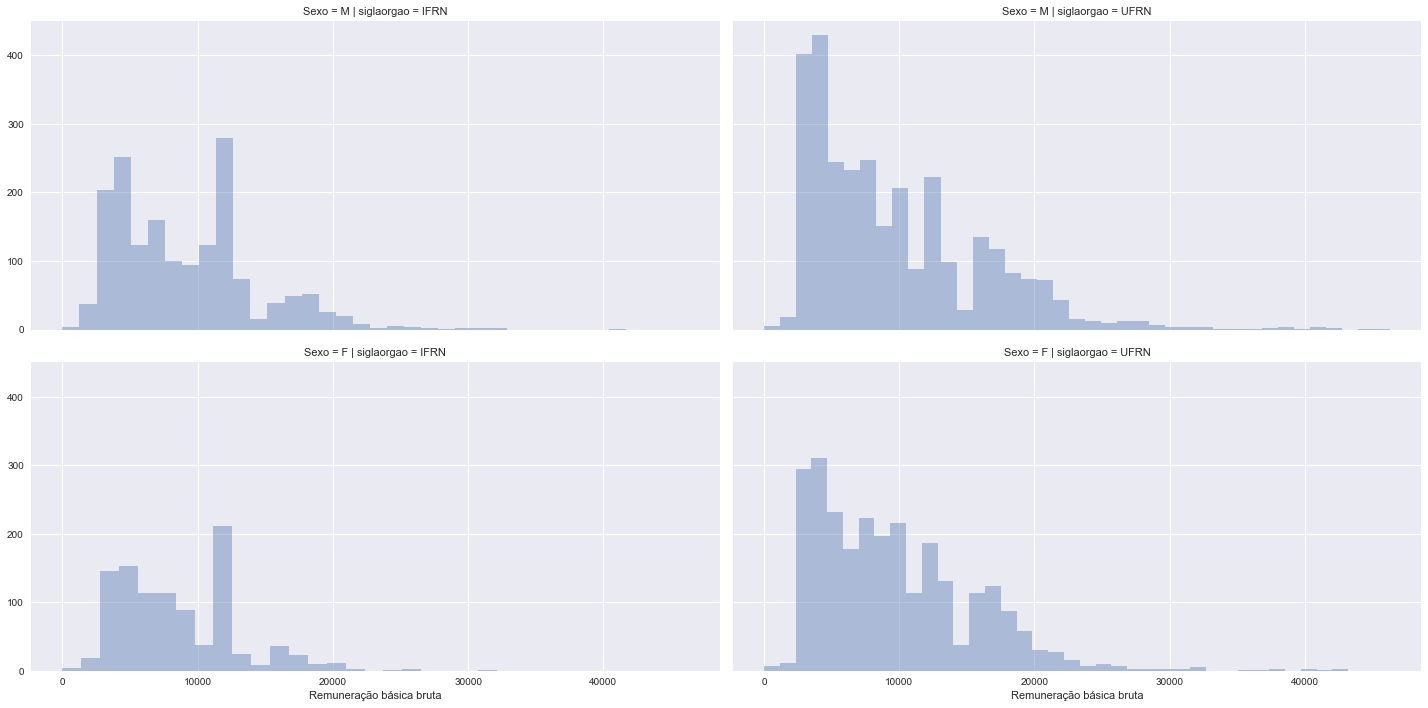

In [87]:
# Plotting the distribution of employees fees by institutions and gender

if_uf_rem_cargo = if_uf[~pd.isnull(if_uf['Remuneração básica bruta'])]

g = sns.FacetGrid(if_uf_rem, row="Sexo", col='siglaorgao', size=5, aspect=2,)
g.map(sns.distplot, 'Remuneração básica bruta', kde=False);

plt.show()

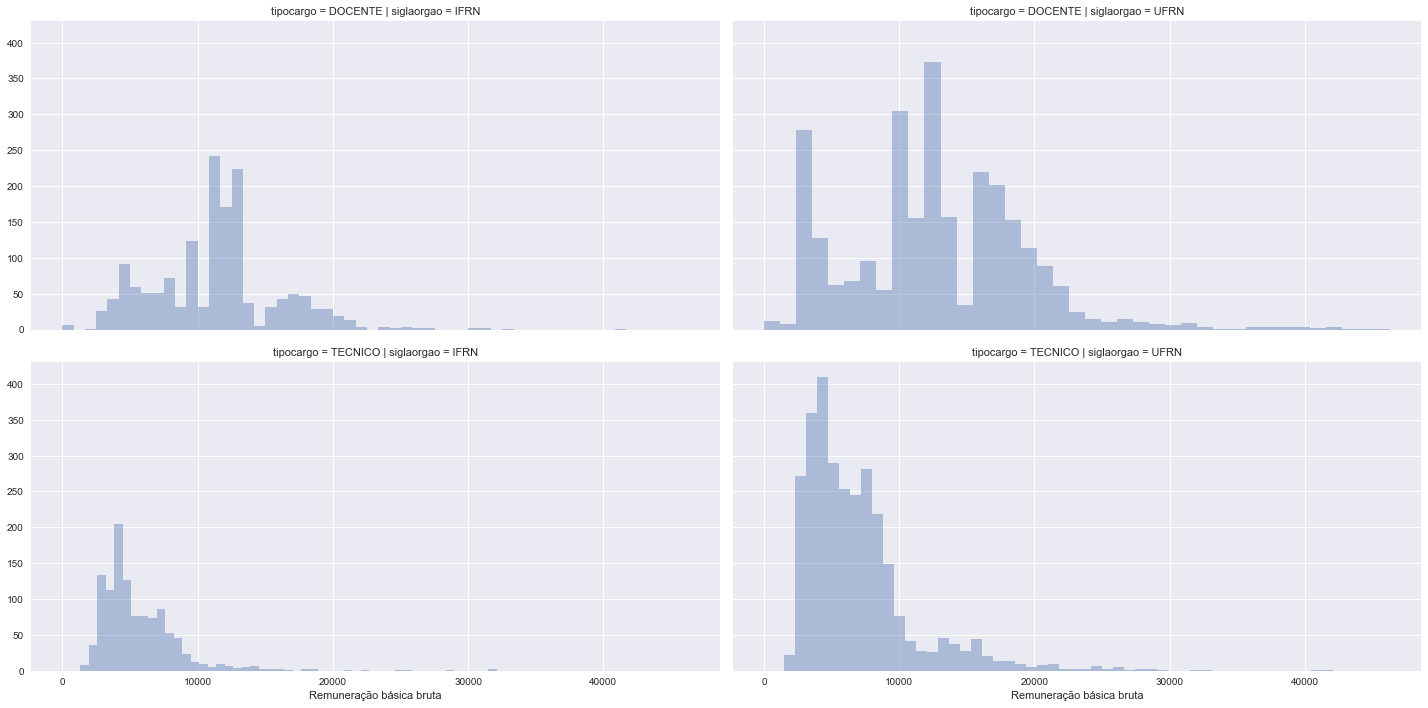

In [88]:
# Create a job type column
if_uf['tipocargo'] = if_uf[~pd.isnull(if_uf['Cargo Emprego'])]['Cargo Emprego'].map(lambda x: 'DOCENTE' if x.split()[0].startswith('PROF') else 'TECNICO')

# Plotting the distribution of employees fees by Institutions and job title
g = sns.FacetGrid(if_uf, row="tipocargo", col='siglaorgao', size=5, aspect=2,)
g.map(sns.distplot, 'Remuneração básica bruta', kde=False);

plt.show()

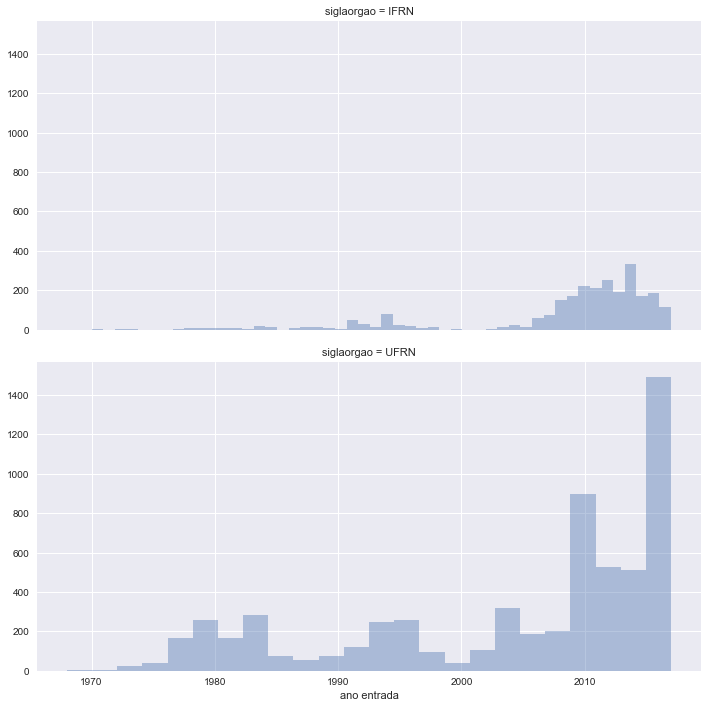

In [122]:
# Plotting the distribution of employees date of entry into institutions

if_uf_dent = if_uf.loc[~pd.isnull(if_uf['Data de publicação'])]
if_uf_dent['ano entrada'] = pd.DataFrame(if_uf_dent['Data de publicação'].map(lambda x: int(x.split('/')[2]) if len(x.split('/'))==3 else 0))
if_uf_dent = if_uf_dent.loc[if_uf_dent['ano entrada']>0]

g = sns.FacetGrid(if_uf_dent, row="siglaorgao",size=5, aspect=2,)
g.map(sns.distplot, 'ano entrada', kde=False);

plt.show()



### UFRN - IMD - Data science class - Alex Furtunato

